## Importing necessary libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, NelsonAalenFitter, KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test
%matplotlib inline

## Loading the data

In [2]:
df = pd.read_csv("Bladder_cancer.csv")
df.head(15)

,id,treatment,number,size,recur,start,stop,status,rtumor,rsize,enum
0,1,placebo,1,1,0,0,0,3,.,.,1
1,2,placebo,1,3,0,0,1,3,.,.,1
2,3,placebo,2,1,0,0,4,0,.,.,1
3,4,placebo,1,1,0,0,7,0,.,.,1
4,5,placebo,5,1,0,0,10,3,.,.,1
5,6,placebo,4,1,1,0,6,1,1,1,1
6,6,placebo,4,1,1,6,10,3,.,.,2
7,7,placebo,1,1,0,0,14,0,.,.,1
8,8,placebo,1,1,0,0,18,0,.,.,1
9,9,placebo,1,3,1,0,5,1,2,4,1


In [3]:
# data description

# id:	Patient id
# treatment:	Placebo, pyridoxine (vitamin B6), or thiotepa
# number:	Initial number of tumours (8=8 or more)
# size:	Size (cm) of largest initial tumour
# recur:	Number of recurrences
# start,stop:	The start and end time of each time interval
# status:	End of interval code, 0=censored, 1=recurrence,
#                                 2=death from bladder disease, 
#                                 3=death other/unknown cause
# rtumor:	Number of tumors found at the time of a recurrence
# rsize:	Size of largest tumor at a recurrence
# enum:	Event number (observation number within patient)

## Data Preparation

In [4]:
# preparing the data: (recurring time in months, delta_i)

mother_df = pd.DataFrame()
for i in df["id"]:
    #if i in recurrent_ids:
    dummy = df[df['id']==i]
    status = dummy['status']
    enum = dummy['enum']
    diff = dummy['stop'] - dummy['start']
    dummy.drop(['status','enum',"start","stop","recur"],axis=1,inplace=True)
    dummy1 = dummy.iloc[0,]
    dummy1["Tis"] = list(zip(diff.values,status.values))
    dummy1["rtumor"] = list(dummy["rtumor"].values)
    dummy1["rsize"] = list(dummy["rsize"].values)

    #print(dummy1)
    mother_df = pd.concat([mother_df,dummy1],axis=1)
    #display(mother_df)
    #break
        
mother_df = mother_df.transpose()
mother_df.drop_duplicates(subset=['id'],inplace=True)
mother_df.reset_index(inplace=True)
mother_df.drop("index",axis=1,inplace=True)

mother_df.head(10)

/home/srijan/.local/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/srijan/.local/lib/python3.8/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/home/srijan/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

,id,treatment,number,size,rtumor,rsize,Tis
0,1,placebo,1,1,[.],[.],"[(0, 3)]"
1,2,placebo,1,3,[.],[.],"[(1, 3)]"
2,3,placebo,2,1,[.],[.],"[(4, 0)]"
3,4,placebo,1,1,[.],[.],"[(7, 0)]"
4,5,placebo,5,1,[.],[.],"[(10, 3)]"
5,6,placebo,4,1,"[1, .]","[1, .]","[(6, 1), (4, 3)]"
6,7,placebo,1,1,[.],[.],"[(14, 0)]"
7,8,placebo,1,1,[.],[.],"[(18, 0)]"
8,9,placebo,1,3,"[2, .]","[4, .]","[(5, 1), (13, 3)]"
9,10,placebo,1,1,"[2, 3, .]","[2, ., .]","[(12, 1), (4, 1), (2, 3)]"


## Seperating the data into two groups : 

- first group (118 unique patients, with only their first event times)
- second group (118 patients with all recurrence times, to be used for frailty modelling) 

In this notebook hereafter, we have worked with the first group only.

## First Group

In [7]:
first_group = mother_df
first_group.head(10)

,id,treatment,number,size,rtumor,rsize,Tis,time_to_first_event,time_to_death,delta,No_of_recurrences,treatment2
0,1,placebo,1,1,[.],[.],"[(0, 3)]",0,0,0,0,placebo
1,2,placebo,1,3,[.],[.],"[(1, 3)]",1,1,0,0,placebo
2,3,placebo,2,1,[.],[.],"[(4, 0)]",4,4,0,0,placebo
3,4,placebo,1,1,[.],[.],"[(7, 0)]",7,7,0,0,placebo
4,5,placebo,5,1,[.],[.],"[(10, 3)]",10,10,0,0,placebo
5,6,placebo,4,1,"[1, .]","[1, .]","[(6, 1), (4, 3)]",6,10,1,1,placebo
6,7,placebo,1,1,[.],[.],"[(14, 0)]",14,14,0,0,placebo
7,8,placebo,1,1,[.],[.],"[(18, 0)]",18,18,0,0,placebo
8,9,placebo,1,3,"[2, .]","[4, .]","[(5, 1), (13, 3)]",5,18,1,1,placebo
9,10,placebo,1,1,"[2, 3, .]","[2, ., .]","[(12, 1), (4, 1), (2, 3)]",12,18,1,2,placebo


In [8]:
# feature engineering

first_group["time_to_first_event"] = first_group["Tis"].apply(lambda x: x[0][0])
first_group["time_to_death"] = first_group["Tis"].apply(lambda x: sum([i[0] for i in x]))
first_group["delta"] = first_group["Tis"].apply(lambda x: int(x[0][1] in [2,1]))  # censored or not indentifier
first_group["No_of_recurrences"] = first_group["Tis"].apply(lambda x: len(x)-1)
first_group["treatment2"] = first_group["treatment"].apply(lambda x: 'placebo' if x=='placebo' else 'non-placebo')

### Preprocessing

In [9]:
def f1(x):
  if x["rtumor"][0]=='.':
    x["rtumor"][0]=x["number"]
  if x["rsize"][0]=='.':
    x["rsize"][0]=x["size"]  
  return x["rtumor"],x["rsize"]

first_group.apply(f1,axis=1)

0                        ([1], [1])
1                        ([1], [3])
2                        ([2], [1])
3                        ([1], [1])
4                        ([5], [1])
                   ...             
113                      ([1], [1])
114    ([1, 1, 1, .], [1, 1, ., .])
115                      ([3], [4])
116                ([2, .], [1, .])
117                      ([1], [3])
Length: 118, dtype: object

In [10]:
first_group.head(15)

,id,treatment,number,size,rtumor,rsize,Tis,time_to_first_event,time_to_death,delta,No_of_recurrences,treatment2
0,1,placebo,1,1,[1],[1],"[(0, 3)]",0,0,0,0,placebo
1,2,placebo,1,3,[1],[3],"[(1, 3)]",1,1,0,0,placebo
2,3,placebo,2,1,[2],[1],"[(4, 0)]",4,4,0,0,placebo
3,4,placebo,1,1,[1],[1],"[(7, 0)]",7,7,0,0,placebo
4,5,placebo,5,1,[5],[1],"[(10, 3)]",10,10,0,0,placebo
5,6,placebo,4,1,"[1, .]","[1, .]","[(6, 1), (4, 3)]",6,10,1,1,placebo
6,7,placebo,1,1,[1],[1],"[(14, 0)]",14,14,0,0,placebo
7,8,placebo,1,1,[1],[1],"[(18, 0)]",18,18,0,0,placebo
8,9,placebo,1,3,"[2, .]","[4, .]","[(5, 1), (13, 3)]",5,18,1,1,placebo
9,10,placebo,1,1,"[2, 3, .]","[2, ., .]","[(12, 1), (4, 1), (2, 3)]",12,18,1,2,placebo


In [11]:
first_group['treatment'].value_counts().sort_index(ascending=True)

placebo       48
pyridoxine    32
thiotepa      38
Name: treatment, dtype: int64

## Basic EDA

([<matplotlib.patches.Wedge at 0x7f0ebdf68760>,
 [Text(-0.08776463606753102, 1.096493214140395, 'Observed'),
  Text(0.08776453340642627, -1.0964932223575083, 'Censored')])

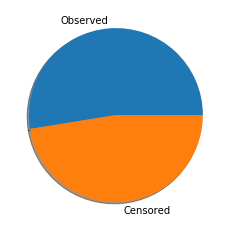

In [12]:
plt.pie(first_group['delta'].value_counts(), labels = ['Observed','Censored'],shadow=True)

/home/srijan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

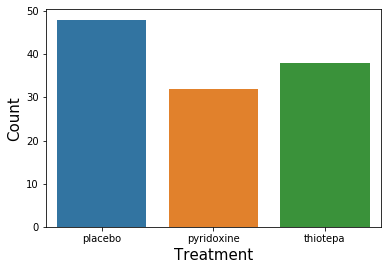

In [13]:
sns.barplot(first_group['treatment'].value_counts().sort_index(ascending=True).index,
            first_group['treatment'].value_counts().sort_index(ascending=True))
plt.xlabel("Treatment",size=15)
plt.ylabel("Count",size=15)

Text(0.5, 1.0, 'Number of recurrences w.r.t treatments')

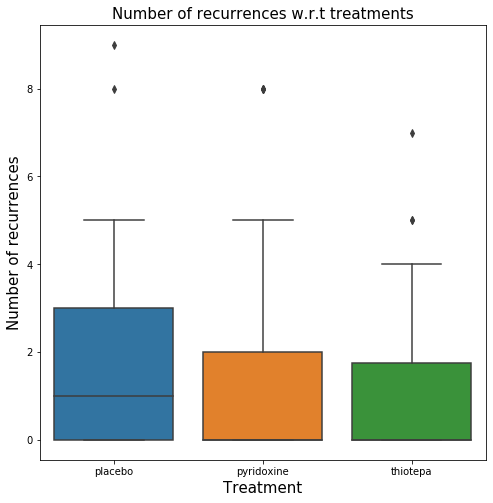

In [14]:
plt.figure(figsize=(8,8))
sns.boxplot(x="treatment", y="No_of_recurrences", data=first_group)
plt.xlabel('Treatment',size = 15)
plt.ylabel('Number of recurrences',size = 15)
plt.title('Number of recurrences w.r.t treatments',size = 15)

Text(0.5, 1.0, 'Number of tumours w.r.t treatments')

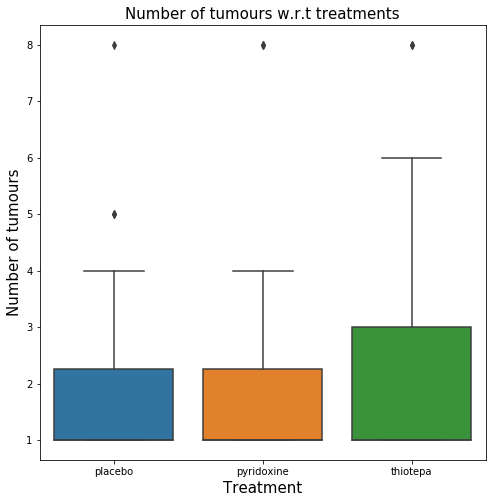

In [15]:
plt.figure(figsize=(8,8))
sns.boxplot(x="treatment", y="number", data=first_group)
plt.xlabel('Treatment',size = 15)
plt.ylabel('Number of tumours',size = 15)
plt.title('Number of tumours w.r.t treatments',size = 15)

In [16]:
first_group["treatment"].value_counts()

placebo       48
thiotepa      38
pyridoxine    32
Name: treatment, dtype: int64

In [17]:
# max time to death in first group

first_group.time_to_death.max()

64

Text(0, 0.5, 'Count')

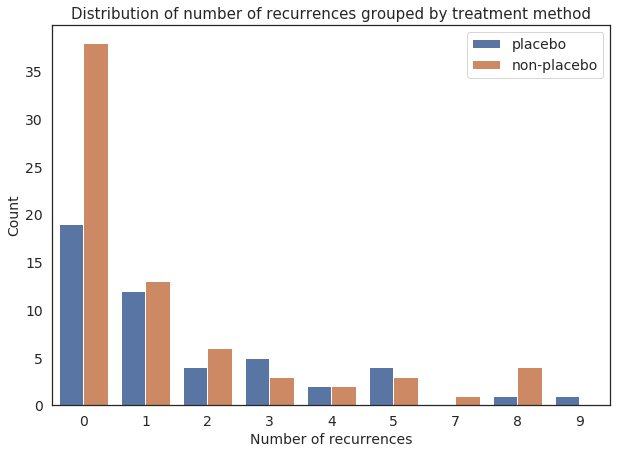

In [18]:
sns.set(style="white")
plt.figure(figsize=(10,7))
sns.countplot(data=first_group, x='No_of_recurrences',hue='treatment2')
plt.legend(loc='upper right',prop={'size': 14})
plt.title("Distribution of number of recurrences grouped by treatment method",size=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Number of recurrences",size=14)
plt.ylabel("Count",size=14)

Text(0, 0.5, 'Count')

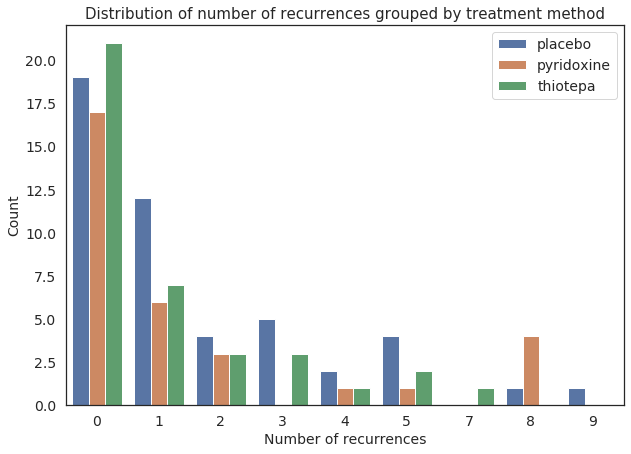

In [19]:
sns.set(style="white")
plt.figure(figsize=(10,7))
sns.countplot(data=first_group, x='No_of_recurrences',hue='treatment')
plt.legend(loc='upper right',prop={'size': 14})
plt.title("Distribution of number of recurrences grouped by treatment method",size=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Number of recurrences",size=14)
plt.ylabel("Count",size=14)

In [20]:
# tumor number value counts

first_group["number"].value_counts()

1    72
2    14
3    13
4     7
5     5
8     5
6     2
Name: number, dtype: int64

Text(0.5, 0, 'Number of tumors')

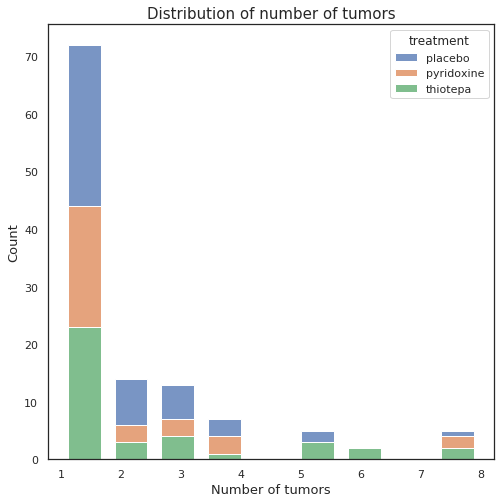

In [21]:
plt.figure(figsize=(8,8))
sns.set_theme(style='white')
sns.histplot(x="number",hue="treatment",multiple="stack",data=first_group,shrink=0.7)
plt.title("Distribution of number of tumors",size=15)
plt.ylabel("Count",size=13)
plt.xlabel("Number of tumors",size=13)

In [22]:
# tumor size value counts

first_group["size"].value_counts()

1    69
3    19
2    14
4     7
6     4
5     2
7     2
8     1
Name: size, dtype: int64

Text(0.5, 0, 'Number of tumors')

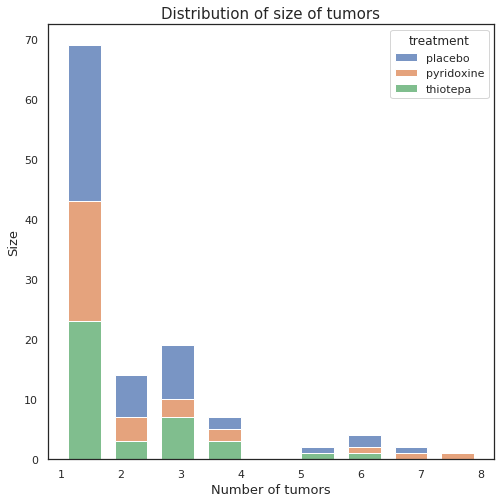

In [23]:
plt.figure(figsize=(8,8))
sns.set_theme(style='white')
sns.histplot(x="size",hue="treatment",multiple="stack",data=first_group,shrink=0.7)
plt.title("Distribution of size of tumors",size=15)
plt.ylabel("Size",size=13)
plt.xlabel("Number of tumors",size=13)

Text(0.5, 0, 'Time (months)')

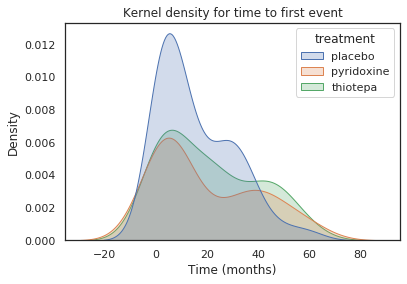

In [24]:
# distribution of survival months over different treatments

sns.kdeplot(data=first_group,x='time_to_first_event',hue='treatment',fill=True)
plt.title("Kernel density for time to first event")
plt.xlabel('Time (months)')

## Kaplan Meyer estimator

### 1. Grouped by treatment methods

Text(0, 0.5, 'Survival Probability')

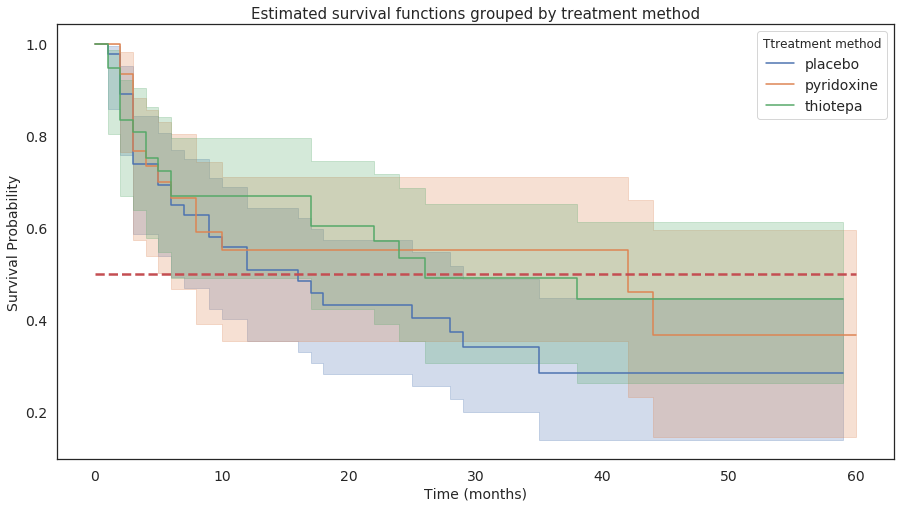

In [25]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(111)

kmf = KaplanMeierFitter()

km_df1 = first_group.loc[:,["treatment","time_to_first_event","delta"]]

for trt in df["treatment"].unique():    
    flag = km_df1["treatment"] == trt    
    kmf.fit(km_df1["time_to_first_event"][flag], event_observed=km_df1["delta"][flag], label=trt)
    kmf.plot(ax=ax1)
plt.plot([0,60],[0.5,0.5],"r--",lw = 2.5)
plt.legend(title="Ttreatment method",loc="upper right",prop={'size': 14})
plt.title('Estimated survival functions grouped by treatment method',size=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (months)',size=14)
plt.ylabel('Survival Probability',size=14)

In [26]:
# log-rank test

def print_logrank(col):
  log_rank = pairwise_logrank_test(km_df1['time_to_first_event'], km_df1[col], km_df1['delta'])
  return log_rank.summary

In [27]:
print_logrank("treatment")

test_statistic         p  -log2(p)
placebo    pyridoxine        1.326279  0.249468  2.003072
           thiotepa          1.520945  0.217477  2.201068
pyridoxine thiotepa          0.001407  0.970077  0.043828

## Thresholding on number of tumours

In [28]:
def thresh(col,x):
    df = first_group.loc[:,[col,"time_to_first_event","delta"]]
    df[f"thresh_{col}_tumour"] = [0 if i < x else 1 for i in first_group.loc[:,col]]
    return df

In [29]:
thresh("number",4)

,number,time_to_first_event,delta,thresh_number_tumour
0,1,0,0,0
1,1,1,0,0
2,2,4,0,0
3,1,7,0,0
4,5,10,0,1
...,...,...,...,...
113,1,50,0,0
114,4,4,1,1
115,3,54,0,0
116,2,38,1,0


In [30]:
thresh("number",4).thresh_number_tumour.value_counts()

0    99
1    19
Name: thresh_number_tumour, dtype: int64

In [31]:
def logrank_thresh(col,x):
    y = thresh(col,x)
    log_rank = pairwise_logrank_test(y['time_to_first_event'], y[f'thresh_{col}_tumour'], y['delta'])
    return log_rank.summary

In [32]:
for i in range(2,9):
    print("p-value when threshold on number of tumours is {} : {}".format(i,logrank_thresh("number",i)['p'].values[0]))

p-value when threshold on number of tumours is 2 : 0.0017939330834322697
p-value when threshold on number of tumours is 3 : 0.007020162822710038
p-value when threshold on number of tumours is 4 : 0.0002594167683235225
p-value when threshold on number of tumours is 5 : 0.0026688648730418267
p-value when threshold on number of tumours is 6 : 0.0010422478423726767
p-value when threshold on number of tumours is 7 : 0.02283357735020892
p-value when threshold on number of tumours is 8 : 0.02283357735020892


### 2. Grouped by thresholded number of tumours

Text(0, 0.5, 'Survival Probability')

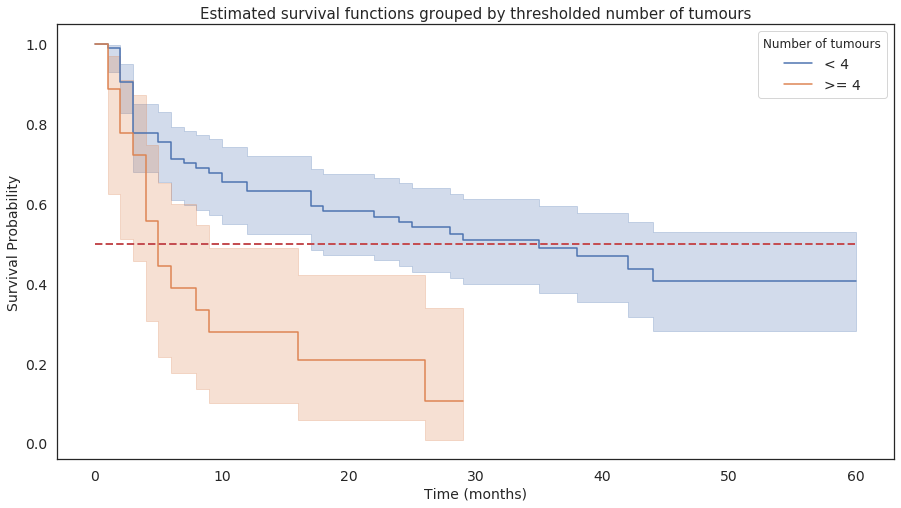

In [33]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(111)

kmf = KaplanMeierFitter()

km_df_thresh = thresh("number",4).loc[:,["thresh_number_tumour","time_to_first_event","delta"]]

for num in km_df_thresh["thresh_number_tumour"].unique():    
    flag = km_df_thresh["thresh_number_tumour"] == num    
    kmf.fit(km_df_thresh["time_to_first_event"][flag], event_observed=km_df_thresh["delta"][flag], label=num)
    kmf.plot(ax=ax1)
plt.plot([0,60],[0.5,0.5],"r--",lw = 2)
plt.legend(['< 4','>= 4'],title="Number of tumours",loc="upper right",prop={'size': 14})
plt.title('Estimated survival functions grouped by thresholded number of tumours',size=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (months)',size=14)
plt.ylabel('Survival Probability',size=14)

# Thresholding on size of tumours

In [34]:
thresh("size",2)

,size,time_to_first_event,delta,thresh_size_tumour
0,1,0,0,0
1,3,1,0,1
2,1,4,0,0
3,1,7,0,0
4,1,10,0,0
...,...,...,...,...
113,1,50,0,0
114,1,4,1,0
115,4,54,0,1
116,1,38,1,0


In [35]:
thresh("size",6).thresh_size_tumour.value_counts()

0    111
1      7
Name: thresh_size_tumour, dtype: int64

In [36]:
for i in range(2,9):
    print("p-value when threshold on size of tumours is {} : {}".format(i,logrank_thresh("size",i)['p'].values[0]))

p-value when threshold on size of tumours is 2 : 0.5199524395300987
p-value when threshold on size of tumours is 3 : 0.3024758137141664
p-value when threshold on size of tumours is 4 : 0.23865366312441283
p-value when threshold on size of tumours is 5 : 0.1682752207760559
p-value when threshold on size of tumours is 6 : 0.1570410142894633
p-value when threshold on size of tumours is 7 : 0.9146316972988796
p-value when threshold on size of tumours is 8 : 0.3025414266710924


### 3. Grouped by thresholded size of tumours

Text(0, 0.5, 'Survival Probability')

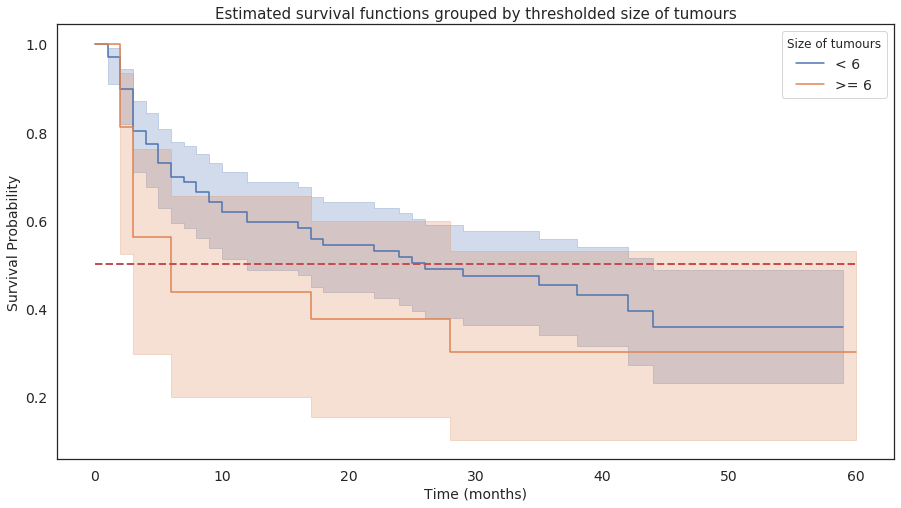

In [44]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(111)

kmf = KaplanMeierFitter()

km_df_thresh = thresh("size",4).loc[:,["thresh_size_tumour","time_to_first_event","delta"]]

for size in km_df_thresh["thresh_size_tumour"].unique():    
    flag = km_df_thresh["thresh_size_tumour"] == size    
    kmf.fit(km_df_thresh["time_to_first_event"][flag], event_observed=km_df_thresh["delta"][flag], label=size)
    kmf.plot(ax=ax1)
plt.plot([0,60],[0.5,0.5],"r--",lw = 2)
plt.legend(['< 6','>= 6'],title="Size of tumours",loc="upper right",prop={'size': 14})
plt.title('Estimated survival functions grouped by thresholded size of tumours',size=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (months)',size=14)
plt.ylabel('Survival Probability',size=14)

## Nelson Aalen estimator

Text(0.5, 1.0, 'Hazard functions by treatment method')

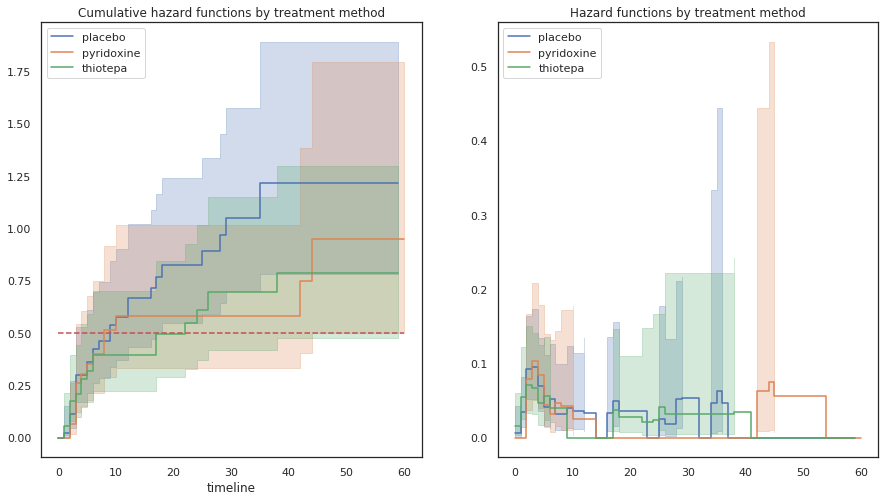

In [38]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(121)

naf = NelsonAalenFitter()

na_df1 = first_group.loc[:,["treatment","time_to_first_event","delta"]]

for trt in df["treatment"].unique():    
    flag = na_df1["treatment"] == trt    
    naf.fit(na_df1["time_to_first_event"][flag], event_observed=na_df1["delta"][flag], label=trt)
    naf.plot(ax=ax1)
plt.plot([0,60],[0.5,0.5],"r--")
plt.legend(loc="upper left")
plt.title('Cumulative hazard functions by treatment method')

ax2 = plt.subplot(122)

naf = NelsonAalenFitter()

na_df1 = first_group.loc[:,["treatment","time_to_first_event","delta"]]

for trt in df["treatment"].unique():    
    flag = na_df1["treatment"] == trt    
    naf.fit(na_df1["time_to_first_event"][flag], event_observed=na_df1["delta"][flag], label=trt)
    naf.plot_hazard(bandwidth=2, ax=ax2)

plt.legend(loc="upper left")
plt.title('Hazard functions by treatment method')